In [1]:
from config import *
import processing
import models
import torch.optim as optim
import torch.nn as nn
import numpy as np
import math
import torch
import json



In [ ]:
processing.preprocess_midi_files('F:\\GitHub\\dataset\\midi_dataset', 'F:\\GitHub\\dataset\\np_dataset')

 [F:\GitHub\dataset\midi_dataset\2_Unlimited\Get_Ready_for_This.mid] [F:\GitHub\dataset\midi_dataset\2_Unlimited\Here_I_Go.mid] [F:\GitHub\dataset\midi_dataset\2_Unlimited\Let_the_Beat_Control_Your_Body.1.mid] [F:\GitHub\dataset\midi_dataset\2_Unlimited\Let_the_Beat_Control_Your_Body.2.mid] [F:\GitHub\dataset\midi_dataset\2_Unlimited\Let_the_Beat_Control_Your_Body.3.mid] [F:\GitHub\dataset\midi_dataset\2_Unlimited\Let_the_Beat_Control_Your_Body.mid] [F:\GitHub\dataset\midi_dataset\2_Unlimited\Maximum_Overdrive.1.mid] [F:\GitHub\dataset\midi_dataset\2_Unlimited\Maximum_Overdrive.mid] [F:\GitHub\dataset\midi_dataset\2_Unlimited\No_Limit.1.mid] [F:\GitHub\dataset\midi_dataset\2_Unlimited\No_Limit.2.mid] [F:\GitHub\dataset\midi_dataset\2_Unlimited\No_Limit.mid] [F:\GitHub\dataset\midi_dataset\2_Unlimited\No_Limits.mid] [F:\GitHub\dataset\midi_dataset\2_Unlimited\No_Limit_extended_.mid] [F:\GitHub\dataset\midi_dataset\2_Unlimited\No_One.1.mid] [F:\GitHub\dataset\midi_dataset\2_Unlimited\No_

C:\Users\Draco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


 [F:\GitHub\dataset\midi_dataset\883\Come_mai_feat._Fiorello_.1.mid] [F:\GitHub\dataset\midi_dataset\883\Come_mai_feat._Fiorello_.2.mid] [F:\GitHub\dataset\midi_dataset\883\Come_mai_feat._Fiorello_.mid] [F:\GitHub\dataset\midi_dataset\883\Con_un_deca.1.mid] [F:\GitHub\dataset\midi_dataset\883\Con_un_deca.mid] [F:\GitHub\dataset\midi_dataset\883\Cumuni.mid] [F:\GitHub\dataset\midi_dataset\883\Dimmi_perche_remix_.mid] [F:\GitHub\dataset\midi_dataset\883\Gli_anni_96_.1.mid] [F:\GitHub\dataset\midi_dataset\883\Gli_anni_96_.mid] [F:\GitHub\dataset\midi_dataset\883\Grazie_mille.1.mid] [F:\GitHub\dataset\midi_dataset\883\Grazie_mille.mid] [F:\GitHub\dataset\midi_dataset\883\Hanno_ucciso_luomo_ragno.1.mid] [F:\GitHub\dataset\midi_dataset\883\Hanno_ucciso_luomo_ragno.2.mid] [F:\GitHub\dataset\midi_dataset\883\Hanno_ucciso_luomo_ragno.mid] [F:\GitHub\dataset\midi_dataset\883\Innamorare_tanto.mid] [F:\GitHub\dataset\midi_dataset\883\Io_ci_saro.1.mid] [F:\GitHub\dataset\midi_dataset\883\Io_ci_saro

In [2]:
train_dataloader, test_dataloader = processing.get_train_test_dataloaders('F:\\GitHub\\dataset\\np_dataset')


In [57]:
with open('F:\\GitHub\\dataset\\midi_dataset\\tokenizations.json', 'r') as f:
    tokenizations = json.load(f)
METADATA_VOCAB_SIZE = tokenizations['VOCAB_SIZE']
model = models.Transformer(VOCAB_SIZE, N_EMBD, N_LAYER, N_HEAD, BLOCK_SIZE, DROPOUT, DEVICE)
model.to(DEVICE)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Training loop
num_epochs = EPOCHS
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0

    for batch_idx, (sequence, metadata) in enumerate(train_dataloader):
        input = sequence[:, :-1].to(DEVICE)
        target = sequence[:, 1:].to(DEVICE)
        output = model(input)
        # loss = criterion(output, target)
        target_one_hot = torch.zeros_like(output)
        target_one_hot.scatter_(-1, target.unsqueeze(-1), 1.0)  # Place 1 at the correct index
        loss = criterion(output, target_one_hot)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_dataloader)}], Loss: {loss.item():.4f}')

    avg_loss = total_loss / len(train_dataloader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}')

    # Validation loop (optional)
    model.eval()  # Set the model to evaluation mode
    val_loss = 0
    with torch.no_grad():
        for sequence, metadata in test_dataloader:
            input = sequence[:, :-1].to(DEVICE)
            target = sequence[:, 1:].to(DEVICE)
            output = model(input)
            target_one_hot = torch.zeros_like(output)
            target_one_hot.scatter_(-1, target.unsqueeze(-1), 1.0)  # Place 1 at the correct index
            loss = criterion(output, target_one_hot)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(test_dataloader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}')

print("Training complete!")

Epoch [1/200], Average Loss: 0.0061
Epoch [1/200], Validation Loss: 0.0050
Epoch [2/200], Average Loss: 0.0047
Epoch [2/200], Validation Loss: 0.0044
Epoch [3/200], Average Loss: 0.0044
Epoch [3/200], Validation Loss: 0.0043
Epoch [4/200], Average Loss: 0.0041
Epoch [4/200], Validation Loss: 0.0042
Epoch [5/200], Average Loss: 0.0042
Epoch [5/200], Validation Loss: 0.0041
Epoch [6/200], Average Loss: 0.0041
Epoch [6/200], Validation Loss: 0.0041
Epoch [7/200], Average Loss: 0.0041
Epoch [7/200], Validation Loss: 0.0042
Epoch [8/200], Average Loss: 0.0041
Epoch [8/200], Validation Loss: 0.0042
Epoch [9/200], Average Loss: 0.0040
Epoch [9/200], Validation Loss: 0.0041
Epoch [10/200], Average Loss: 0.0041
Epoch [10/200], Validation Loss: 0.0042
Epoch [11/200], Average Loss: 0.0040
Epoch [11/200], Validation Loss: 0.0041
Epoch [12/200], Average Loss: 0.0042
Epoch [12/200], Validation Loss: 0.0041
Epoch [13/200], Average Loss: 0.0041
Epoch [13/200], Validation Loss: 0.0041
Epoch [14/200], A

KeyboardInterrupt: 

In [45]:
# dataset = processing.SequenceDataset("F:\\GitHub\\dataset\\np_dataset")
for sequence, metadata in test_dataloader:
    input = sequence[:, :-1].to(DEVICE)
    target = sequence[:, 1:].to(DEVICE)
    output = model(input)

In [68]:
print(output[0][1][0][657])
print(output.argmax(-1))
print(target)

tensor(-1.7259, device='cuda:0', grad_fn=<SelectBackward0>)
tensor([[[657, 657, 657, 657, 657, 657],
         [657, 657, 657, 657, 657, 657],
         [657, 657, 657, 657, 657, 657],
         ...,
         [657, 657, 657, 657, 657, 657],
         [657, 657, 657, 657, 657, 657],
         [657, 657, 657, 657, 657, 657]],

        [[657, 657, 657, 657, 657, 657],
         [657, 657, 657, 657, 657, 657],
         [657, 657, 657, 657, 657, 657],
         ...,
         [657, 657, 657, 657, 657, 657],
         [657, 657, 657, 657, 657, 657],
         [657, 657, 657, 657, 657, 657]],

        [[657, 657, 657, 657, 657, 657],
         [657, 657, 657, 657, 657, 657],
         [657, 657, 657, 657, 657, 657],
         ...,
         [657, 657, 657, 657, 657, 657],
         [657, 657, 657, 657, 657, 657],
         [657, 657, 657, 657, 657, 657]],

        ...,

        [[657, 657, 657, 657, 657, 657],
         [657, 657, 657, 657, 657, 657],
         [657, 657, 657, 657, 657, 657],
         ...,
   

In [11]:
loss

tensor(0.7324, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

<BarContainer object of 1485 artists>

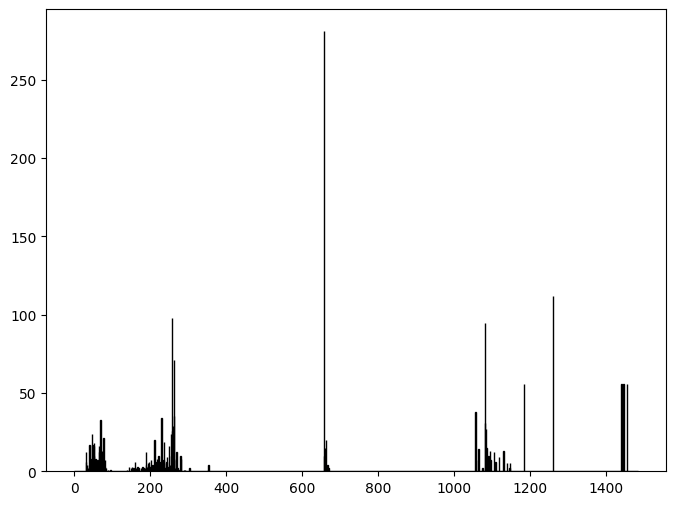

In [56]:
flattened_tensor = input.flatten()
bins = VOCAB_SIZE
hist = torch.histc(flattened_tensor.int(), bins=bins, min=0, max=VOCAB_SIZE)
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.bar(range(bins), hist.cpu().int().numpy(), width=1, align='center', color='blue', edgecolor='black')
